In [ ]:
from datasets.gameoflife import GameOfLifeGraph
from datasets.onedimensionalca import OneDimensionalAutomataGridGraph
import matplotlib.pyplot as plt
import numpy as np

Visualize Input/Output pairs

values tensor([[1., 1., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 1., 1.],
        [0., 1., 0., 0., 0.],
        [1., 0., 1., 1., 0.]])


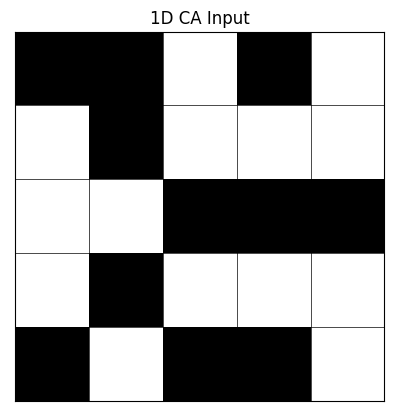

values [[1. 0. 0. 1. 1.]
 [1. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1.]]


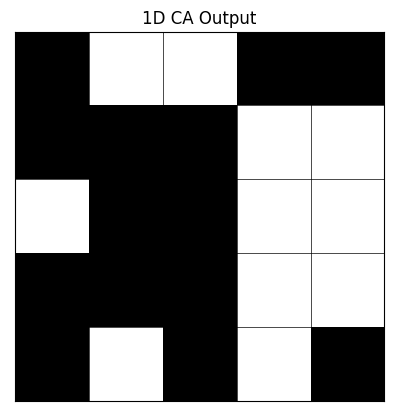

In [6]:
GRID_SIZE = 5
RULE_NUMBER = 30

dataset = OneDimensionalAutomataGridGraph(num_graphs=1, grid_size=GRID_SIZE, steps=1, rule_number=RULE_NUMBER).data

def plot_grid(values, grid_size, title=None):
    print("values", values)
    fig, ax = plt.subplots()
    ax.imshow(values, cmap="gray_r")

    # Draw grid lines
    for x in range(grid_size+1):
        ax.axhline(x-0.5, color='black', linewidth=0.5)
        ax.axvline(x-0.5, color='black', linewidth=0.5)

    plt.title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()

graph = dataset[0]
plot_grid(graph.x.reshape(GRID_SIZE, GRID_SIZE), GRID_SIZE, "1D CA Input")
plot_grid(graph.y.numpy().reshape(GRID_SIZE, GRID_SIZE), GRID_SIZE, "1D CA Output")



Visualize Rule

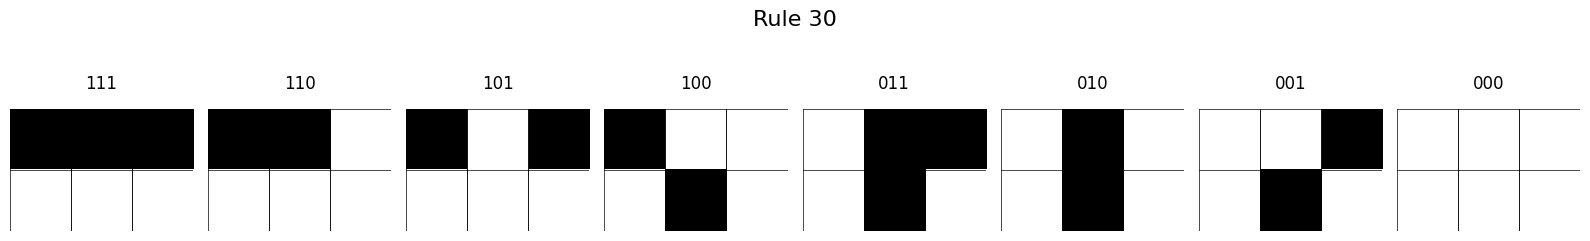

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_rule(rule_number):
    rule_bin = format(rule_number, '08b')[::-1]  # binary representation of the rule, reversed for easy indexing
    
    fig, axs = plt.subplots(1, 8, figsize=(16, 2))
    
    # All 8 possible configurations
    configurations = np.array([[1, 1, 1],
                               [1, 1, 0],
                               [1, 0, 1],
                               [1, 0, 0],
                               [0, 1, 1],
                               [0, 1, 0],
                               [0, 0, 1],
                               [0, 0, 0]])
    
    # Resulting states based on the rule
    results = np.array([int(rule_bin[i]) for i in range(8)])
    results = results[::-1]
    
    # Plot configurations and results
    for i, (config, res) in enumerate(zip(configurations, results)):
        grid = np.array([config, [0, res, 0]])
        axs[i].imshow(grid, cmap='gray_r', aspect='equal')
        axs[i].set_title(f"{config[0]}{config[1]}{config[2]}", pad=15)
        axs[i].axis('off')
        
        # Adding gridlines for the top row
        for j in range(4):
            axs[i].axvline(x=j - 0.5, color='black', linewidth=0.5)
        axs[i].axhline(y=-0.5, color='black', linewidth=0.5)
        axs[i].axhline(y=0.5, color='black', linewidth=0.5)

        # Gridlines for the center box in the second row
        axs[i].axhline(y=1.5, color='black', linewidth=0.5)
        axs[i].axvline(x=0.5, color='black', linewidth=0.5)
        axs[i].axvline(x=1.5, color='black', linewidth=0.5)
    
    plt.tight_layout()
    plt.suptitle(f"Rule {rule_number}", y=1.3, fontsize=16)
    plt.show()
 
# For example, to visualize rule 30:
visualize_rule(30)


Visualize Output from Model

In [ ]:
import torch 
# todo change model import path
model = torch.load("runs/ca/ca_rule_30_1694446497978212000.pt")
model.set_hardmax(True)

def map_x_to_state(xs):
    outputs = []
    for x in xs:
        output = [0,0]
        output[int(x.item())] = 1
        
        outputs.append(output)
    outputs = torch.tensor(outputs)
    return outputs

input_values = map_x_to_state(graph.x)
output_values = model(input_values, graph.edge_index)
output_values = torch.argmax(output_values, dim=-1)
plot_grid(output_values.numpy().reshape(5, 5), 5, "CA Rule 30 Model Output")

Visualize Trained FSM

In [ ]:
# extracting multiple state machines (we trained a state machine for each input class)
from graphviz import Digraph
from itertools import product

all_added = []

for start_id in range(0,2):
    G = Digraph(graph_attr={'rankdir':'LR'}, node_attr={'shape':'circle', "width": "0.8"})

    state_names = ['s0', 's1']

    G.node(state_names[0], penwidth='3px')
    G.node(state_names[1], penwidth='3px')

    added = []
    
    train_dataset = OneDimensionalAutomataGridGraph(num_graphs=200, grid_size=GRID_SIZE, steps=1, rule_number=RULE_NUMBER).data

    for j in range(len(train_dataset)):
            
        model.set_hardmax(True)
        model.set_logging(True)

        out, all_states, transitions = model(map_x_to_state(train_dataset[j].x), train_dataset[j].edge_index)
        out = torch.argmax(out, dim=-1)

        for i in range(GRID_SIZE * GRID_SIZE):
            
            current_state = torch.argmax(all_states[0][i], dim=-1).item()
            if start_id != current_state:
                continue

            for j in range(1,2):
                next_state = torch.argmax(all_states[j][i], dim=-1).item()
                transition_value = str(transitions[j-1][i].tolist())

                transitionTuple = (state_names[current_state], state_names[next_state], transition_value)

                if transitionTuple not in added:
                                            
                    G.edge(state_names[current_state], state_names[next_state], transition_value)
                    added.append(transitionTuple)

                current_state = next_state
        
        all_added += added

    print("starting state s", start_id)
    G.render('task0_ref_fsm', format='svg')
    display(G)

Code to identify rule number learned by model and visualize it

In [ ]:
def identify_rule_from_transitions(added, state_names):
    rule_bin = ['0'] * 8  # start with rule 0 (all zeros)
    
    for transition in added:
        start_state, end_state, transition_value = transition
        
        # Cleaning up the string to extract values
        transition_value = transition_value.replace('[', '').replace(']', '')
        
        # Extracting states from transition_value string
        left_neighbour, right_neighbour = [int(float(s)) for s in transition_value.split(",")]
        
        # Using states to get the index
        idx = int(f"{left_neighbour}{state_names.index(start_state)}{right_neighbour}", 2)
        
        rule_bin[idx] = str(state_names.index(end_state))
    rule_bin.reverse() 
    rule_number = int("".join(rule_bin), 2)
    return rule_number

rule_number = identify_rule_from_transitions(all_added, state_names)
print("Identified rule:", rule_number)
# numbering is the other way for rules
visualize_rule(rule_number)
